In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

Set parameters

In [152]:
tf = 10800 #time in seconds for three hours (s)
xf = 1600  # fire spread area (m)

m = 41
n = int(tf/1) 

dx = xf/(m-1)
dt = 1      #time step

Tc = 1200       #initial temperature (I think???)
#T = a vector defined below       #temperature of fire layer (K)
k = 2.1360*10**-1       #thermal diffusivity (m^2/s)
A = 1.8793 *10**2       #temperature rise per second at maximum burning rate with full inital fuel load and no cooling present (K/s)
B = 5.5849 * 10**2          #proportionality coefficient in Arrhenius law (K)
C = 4.8372 * 10**-5          #scaled coefficient of heat transfer to environment (1/K)
Cs = 1.6250 *10**-1      #fuel relative disappearance rate (1/s)
Ta = 0         #ambient temperature (K)
v = 40         #wind speed (m/s)

C = v * (dt/dx)
Cd = (k*dt)/(dx)**2
#C

Pre-allocate vectors

In [180]:
t = np.linspace(0,tf,n) #time
S = np.zeros(n)    #fuel supply mass fraction [0,1]

T = np.zeros(m)    #temperature at all points in space, will be recalculated for each t, at T(t=0)=Tc (HOW DO WE find i+1?)
Tall = np.zeros((m,m))

#initial conditions
S[0] = 1                # fuel supply starts at full capacity 
T[0]=Tc



In [172]:
deF_burn = lambda S,T,Ta: S*(np.exp(-B/(T-Ta)))   #rate fuel is consumed due to burning
deH_atm = lambda T,Ta: A * C * (T-Ta)   #convective heat lost to atmosphere

#Advec_term = lambda : -((v*dt)/(2*dx))()
#Diff_term = lambda : 
# these two will be calculated below using matrix equations and then added to dT 



dT = lambda S,T, Ta: (A*deF_burn(S, T, Ta) - deH_atm(T, Ta)) #PDE Missing the diffusin an dadvection terms. added while constructing matrix.
dS = lambda deF_burn: -Cs*deF_burn

Create for loop to construct matrix. using FE for calculating S, and using upwind scheme for calculating advection and centered differencing scheme for diffusion

In [178]:
# centered differencing scheme for diffusion term

## isnt the length of the matrix in the time domain supposed to be length of the time vector? why is the matrix not a square matrix in the wildfire smoke advection example?

T1 = np.zeros((m,m)); T2 = np.zeros((m,m))

for i in np.arange(0,m):
    for j in np.arange(0,m):
        if i-1 ==j:
            T1[i,j] = -(1/2)*Cd
        elif i+1 == j:
            T1[i,j] = -(1/2)*Cd
        elif i==j:
            T1[i,j] = (1+Cd)
for i in np.arange(0,m):
    for j in np.arange(0,m):
        if i-1 ==j:
            T2[i,j] = (1/2)*Cd
        elif i+1 == j:
            T2[i,j] = (1/2)*Cd
        elif i==j:
            T2[i,j] = (1-Cd)
            
T1 = np.linalg.inv(T1)
TT = T1*T2
for i in np.arange(0,m):
    Tdiff = np.dot(TT,T)        # How do we make this time varying? / Right now it's just a vector. (IS THis the diffusion term?)


# upwind scheme for advection term
for i in np.arange(0,m):
    for j in np.arange(0,m):
        if i==j:
            Tall[i,j] = 1-C
        elif i-1==j:
            Tall[i,j] = C

#for loop calculating S and T at i+1   

for i in np.arange(0,m):
    S[i+1] = S[i] + dS(deF_burn(S[i],T[i],Ta))
    #calculating T at i+1 for diffusion term 
    #WE WOULD HAVE TO Calculate a T vector (for :,x) at all t to update the below
    for j in np.arange(0,m):
        #this should be updating the Tall matrix, at every point along the respective diagonals, where every point
        # would be (diffusion term - advection term + dT) where dT is diven above, which is the temperature change due to heat lost to atm and fuel lost due to burning
        Tall[i,j] = Tall[i,j]-Tdiff[i]+ dT(S[i],T[i],Ta)
    
    #We should be updating T vector above, Tall[i+1] = T[i] + dT
    # and for j in np.arange(0,m):
    #             we would use the comments below the most recent for loop with j.
          

<ipython-input-172-ab5887833746>:1: RuntimeWarning: divide by zero encountered in double_scalars
  deF_burn = lambda S,T,Ta: S*(np.exp(-B/(T-Ta)))   #rate fuel is consumed due to burning


[0.00000000e+00 2.77803500e-04 5.55607001e-04 ... 2.99944439e+00
 2.99972220e+00 3.00000000e+00]


ValueError: x and y must have same first dimension, but have shapes (10800,) and (41,)

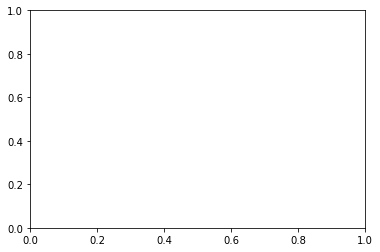

In [179]:
time = t/3600
print(time)
plt.plot(time,T)
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Combustion wave, propogation of fire layer at surface")
plt.show()
